<a href="https://colab.research.google.com/github/abdulrahimq/audio-to-stress/blob/main/wav_to_vec_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: https://github.com/openai/whisper/blob/main/whisper/audio.py

In [2]:
from whisper import audio

In [4]:
array = audio.load_audio("LL-Q55633582_%28ajp%29-AdrianAbdulBaha-%D8%A2%D8%B3%D9%8A%D8%A7.wav")
print(array)

[1.5258789e-04 2.1362305e-04 3.0517578e-04 ... 1.2207031e-04 9.1552734e-05
 9.1552734e-05]


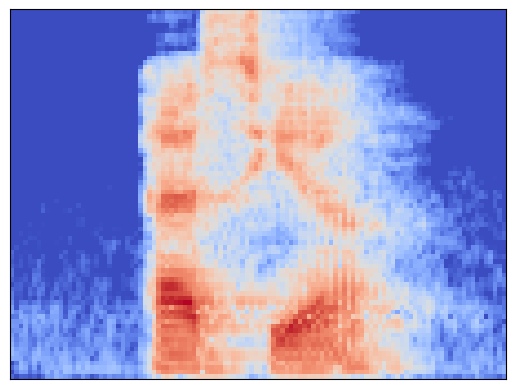

In [5]:
import librosa
import numpy as np
sp = np.array(audio.log_mel_spectrogram(array, 80, 0))
librosa.display.specshow(sp)